In [1]:
from analysis_tools.read_traj import ReadTraj
from analysis_tools.feature_creation import FrameToFeaturesPosition, TrajectoryToFeaturesPosition
from analysis_tools.feature_creation import FrameToFeaturesComposition, TrajectoryToFeaturesComposition
from analysis_tools.radial_distribution_function import RDF, PositionalSuceptibility
from analysis_tools.reservoir_sampler import ReservoirSampler
from analysis_tools.defect_analysis import DefectStats
from analysis_tools.pop2d import POP2D
import gc
from IPython.display import clear_output
import h5py

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
def DownSampleFrames(frames, frame_samples):
    return frames[0::max(len(frames)/frame_samples, 1)][0:frame_samples]

## Specify the conditions

In [6]:
from numpy import arange, array

In [7]:
#VERSION FOR PAPER I
N_nn = 3200 #number of nearest neighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
nn_inc = 50 #1 (full in paper) #reduces the number of nearest neighbors to include as features
remove_types = []
shuffle_data = True
N_batch = 1
batches_per_frame = 1 

In [275]:
#TEST
N_nn = 29 #number of nearest neighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
nn_inc = 1 #1 (full in paper) #reduces the number of nearest neighbors to include as features
remove_types = []
shuffle_data = True
N_batch = 1
batches_per_frame = 1 #10 #5

In [8]:
#specify what data to read in and process
traj_type = 'gsd'
file_data = [(arange(0.550, 0.690001, 0.005), '../hoomd_disks/trajectories_4000p', 400), 
             (arange(0.695, 0.820001, 0.005),'../hoomd_disks/trajectories_4000p_longer', 400)]

In [9]:
#actual data
etas = []
[etas.extend(etas_) for etas_, _, _ in file_data]
etas = array(etas)
color_ids = []
[color_ids.extend(len(data[0])*[count]) for count, data in zip(range(len(file_data)), file_data)]
color_ids = array(color_ids)

## Read in the data

In [10]:
from numpy import array_split
from sklearn.decomposition import IncrementalPCA

In [11]:
corrected_features = []
incpca_ig = IncrementalPCA(n_components=None, whiten=True) 
force_randomize = False

#loop over data sets 
for phase in ['fit_whitener', 'correct_features']:
    raw_features = []
    
    for etas_, file_base, frame_samples in file_data:

        for eta in etas_:
            print 'COMPUTATION DETAILS'
            print 'file_base = {}'.format(file_base)
            print 'eta = {}'.format(eta)

            #read in data and randomize positions if performing ideal gas correction
            filename = "{}/trajectory_{:.4f}.{}".format(file_base, eta, traj_type)
            randomize = (phase == 'fit_whitener') or force_randomize
            frames = ReadTraj(filename, traj_type, shuffle_data, randomize, remove_types)

            #control the number of total frames to analyze
            len_frames_init = len(frames)
            frames = DownSampleFrames(frames, frame_samples)
            print 'using {} frames of {} total'.format(len(frames), len_frames_init)
            
            raw_features.extend(TrajectoryToFeaturesPosition(frames, 
                                                             N_nn=N_nn,  
                                                             nn_inc=nn_inc,
                                                             N_batch=N_batch, 
                                                             batches_per_frame=batches_per_frame))
    if phase == 'fit_whitener':
        print 'Fitting the whitener\n'
        incpca_ig.fit(raw_features)
    else:
        print 'Correcting features\n'
        corrected_features = incpca_ig.transform(raw_features)
            
            

COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.55
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.555
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.56
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.565
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.57
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.575
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.58
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.585
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.59
using 400 frames of 1000 total
COMPUTATION DETAILS
file

using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.645
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.65
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.655
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.66
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.665
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.67
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.675
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.68
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.685
using 400 frames of 100

# Autoencoding

In [13]:
from analysis_tools.autoencoder import AutoEncoder
from sklearn.model_selection import train_test_split

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [14]:
dim = corrected_features.shape[1]
print "Dimensionality: {}".format(dim)

Dimensionality: 64


### Train and test sets

In [15]:
corrected_features_train, corrected_features_test = train_test_split(corrected_features, test_size=0.25, random_state=42)

### Build and train the model

In [121]:
from keras.callbacks import ModelCheckpoint
from numpy import savetxt

In [192]:
dim

64

In [202]:
model = AutoEncoder(dim=dim, encode_dim=1, num_clones=1,
                    initial_growth=0.25, shrink=0.50,
                    activation='elu')#, kernel_initializer='lecun_normal')

In [203]:
model.autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 64)                0         
_________________________________________________________________
lambda_10 (Lambda)           (None, 64)                0         
_________________________________________________________________
model_48 (Model)             (None, 64)                19143     
Total params: 19,143
Trainable params: 19,143
Non-trainable params: 0
_________________________________________________________________


In [204]:
print model.layer_dims

[80, 40, 20, 10, 5, 2, 1, 2, 5, 10, 20, 40, 80, 64]


In [205]:
model.Compile(optimizer='adamax', loss='mean_squared_error')

In [206]:
checkpointer = ModelCheckpoint(filepath='./model/weights_linear.hdf5', verbose=1, save_best_only=True)

In [207]:
history_raw = model.Fit(corrected_features_train, corrected_features_test,
                epochs=2000, batch_size=500, shuffle=True)#, callbacks=[checkpointer])

Train on 16500 samples, validate on 5500 samples
Epoch 1/2000
16500/16500 [==============================] - 0s - loss: 0.5806 - val_loss: 0.4508
Epoch 2/2000
16500/16500 [==============================] - 0s - loss: 0.4199 - val_loss: 0.4021
Epoch 3/2000
16500/16500 [==============================] - 0s - loss: 0.4017 - val_loss: 0.3989
Epoch 4/2000
16500/16500 [==============================] - 0s - loss: 0.4002 - val_loss: 0.3983
Epoch 5/2000
16500/16500 [==============================] - 0s - loss: 0.3996 - val_loss: 0.3978
Epoch 6/2000
16500/16500 [==============================] - 0s - loss: 0.3992 - val_loss: 0.3974
Epoch 7/2000
16500/16500 [==============================] - 0s - loss: 0.3989 - val_loss: 0.3971ss:
Epoch 8/2000
16500/16500 [==============================] - 0s - loss: 0.3986 - val_loss: 0.3969
Epoch 9/2000
16500/16500 [==============================] - 0s - loss: 0.3983 - val_loss: 0.3965
Epoch 10/2000
16500/16500 [==============================] - 0s - loss: 0.3

16500/16500 [==============================] - 0s - loss: 0.3908 - val_loss: 0.3898
Epoch 85/2000
16500/16500 [==============================] - 0s - loss: 0.3906 - val_loss: 0.3895
Epoch 86/2000
16500/16500 [==============================] - 0s - loss: 0.3905 - val_loss: 0.3894
Epoch 87/2000
16500/16500 [==============================] - 0s - loss: 0.3903 - val_loss: 0.3891
Epoch 88/2000
16500/16500 [==============================] - 0s - loss: 0.3901 - val_loss: 0.3890
Epoch 89/2000
16500/16500 [==============================] - 0s - loss: 0.3900 - val_loss: 0.3888
Epoch 90/2000
16500/16500 [==============================] - 0s - loss: 0.3897 - val_loss: 0.3888
Epoch 91/2000
16500/16500 [==============================] - 0s - loss: 0.3896 - val_loss: 0.3883
Epoch 92/2000
16500/16500 [==============================] - 0s - loss: 0.3893 - val_loss: 0.3885
Epoch 93/2000
16500/16500 [==============================] - 0s - loss: 0.3890 - val_loss: 0.3879
Epoch 94/2000
16500/16500 [=======

16500/16500 [==============================] - 0s - loss: 0.3722 - val_loss: 0.3749
Epoch 168/2000
16500/16500 [==============================] - 0s - loss: 0.3718 - val_loss: 0.3747
Epoch 169/2000
16500/16500 [==============================] - 0s - loss: 0.3718 - val_loss: 0.3745
Epoch 170/2000
16500/16500 [==============================] - 0s - loss: 0.3717 - val_loss: 0.3745
Epoch 171/2000
16500/16500 [==============================] - 0s - loss: 0.3717 - val_loss: 0.3746
Epoch 172/2000
16500/16500 [==============================] - 0s - loss: 0.3716 - val_loss: 0.3746
Epoch 173/2000
16500/16500 [==============================] - 0s - loss: 0.3715 - val_loss: 0.3744
Epoch 174/2000
16500/16500 [==============================] - 0s - loss: 0.3715 - val_loss: 0.3743
Epoch 175/2000
16500/16500 [==============================] - 0s - loss: 0.3713 - val_loss: 0.3747
Epoch 176/2000
16500/16500 [==============================] - 0s - loss: 0.3712 - val_loss: 0.3742
Epoch 177/2000
16500/1650

16500/16500 [==============================] - 0s - loss: 0.3682 - val_loss: 0.3724
Epoch 250/2000
16500/16500 [==============================] - 0s - loss: 0.3683 - val_loss: 0.3722
Epoch 251/2000
16500/16500 [==============================] - 0s - loss: 0.3683 - val_loss: 0.3722
Epoch 252/2000
16500/16500 [==============================] - 0s - loss: 0.3683 - val_loss: 0.3724
Epoch 253/2000
16500/16500 [==============================] - 0s - loss: 0.3681 - val_loss: 0.3720
Epoch 254/2000
16500/16500 [==============================] - 0s - loss: 0.3681 - val_loss: 0.3721
Epoch 255/2000
16500/16500 [==============================] - 0s - loss: 0.3681 - val_loss: 0.3724
Epoch 256/2000
16500/16500 [==============================] - 0s - loss: 0.3681 - val_loss: 0.3721
Epoch 257/2000
16500/16500 [==============================] - 0s - loss: 0.3681 - val_loss: 0.3719
Epoch 258/2000
16500/16500 [==============================] - 0s - loss: 0.3680 - val_loss: 0.3720
Epoch 259/2000
16500/1650

16500/16500 [==============================] - 0s - loss: 0.3665 - val_loss: 0.3707
Epoch 332/2000
16500/16500 [==============================] - 0s - loss: 0.3665 - val_loss: 0.3706
Epoch 333/2000
16500/16500 [==============================] - 0s - loss: 0.3666 - val_loss: 0.3705
Epoch 334/2000
16500/16500 [==============================] - 0s - loss: 0.3665 - val_loss: 0.3707
Epoch 335/2000
16500/16500 [==============================] - 0s - loss: 0.3665 - val_loss: 0.3704
Epoch 336/2000
16500/16500 [==============================] - 0s - loss: 0.3665 - val_loss: 0.3704
Epoch 337/2000
16500/16500 [==============================] - 0s - loss: 0.3664 - val_loss: 0.3701
Epoch 338/2000
16500/16500 [==============================] - 0s - loss: 0.3663 - val_loss: 0.3705
Epoch 339/2000
16500/16500 [==============================] - 0s - loss: 0.3663 - val_loss: 0.3701
Epoch 340/2000
15000/16500 [==========================>...] - ETA: 0s - loss: 0.3658

KeyboardInterrupt: 

In [78]:
#savetxt('./model/val_loss_linear.txt', history_raw.history['val_loss'])

### Check out the results 

In [208]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
%matplotlib inline 

In [209]:
encoded_data = model.Encode(corrected_features)

In [210]:
from numpy import mean

In [211]:
OP = []
for i in range(len(etas)):
    OP.append(mean(encoded_data[:,0][i*400:i*400+400]))

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


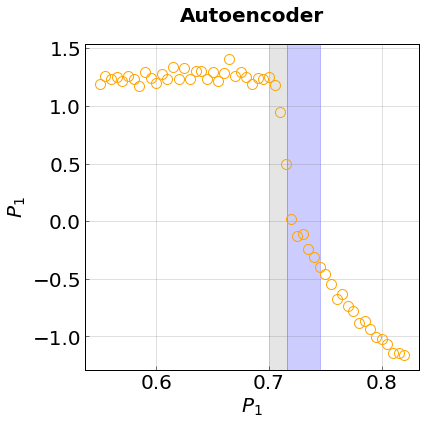

In [213]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

plt.plot(etas, array(OP), marker='o', linewidth=0.0, markersize=10, color = 'orange', alpha=1.0, markerfacecolor='None') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


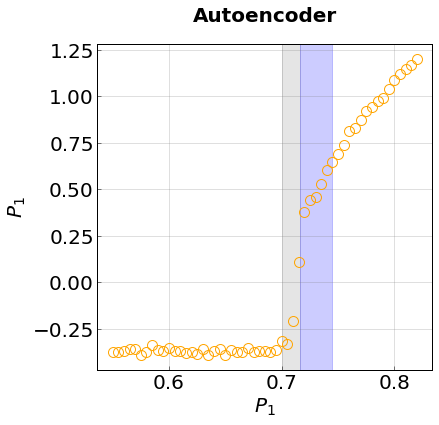

In [134]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

plt.plot(etas, array(OP), marker='o', linewidth=0.0, markersize=10, color = 'orange', alpha=1.0, markerfacecolor='None') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


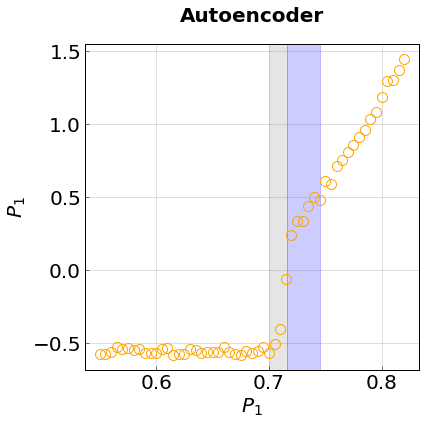

In [47]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

plt.plot(etas, array(OP), marker='o', linewidth=0.0, markersize=10, color = 'orange', alpha=1.0, markerfacecolor='None') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

## Check out the 10 iterations

In [87]:
from numpy import mean, loadtxt

In [19]:
model = AutoEncoder(dim=dim, encode_dim=1, 
                    initial_growth=0.25, shrink=0.65,
                    activation='selu', kernel_initializer='lecun_normal')

In [90]:
OP_set = []
error_set = []
for i in range(10):
    print i
    model.autoencoder.load_weights('./model/weights_{}.hdf5'.format(i))
    model.Compile(optimizer='adamax', loss='mean_squared_error')
    encoded_data = model.Predict(corrected_features)
    OP = []
    for j in range(len(etas)):
        OP.append(mean(encoded_data[:,0][j*400:j*400+400]))
    OP_set.append(OP)
    error_set.append(loadtxt('./model/val_loss_{}.txt'.format(i)))

print 'linear'
model.autoencoder.load_weights('./model/weights_linear.hdf5'.format(i))
model.Compile(optimizer='adamax', loss='mean_squared_error')
encoded_data = model.Predict(corrected_features)
OP_linear = []
for i in range(len(etas)):
    OP_linear.append(mean(encoded_data[:,0][i*400:i*400+400]))
error_linear = loadtxt('./model/val_loss_linear.txt')

0
1
2
3
4
5
6
7
8
9
linear


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  app.launch_new_instance()


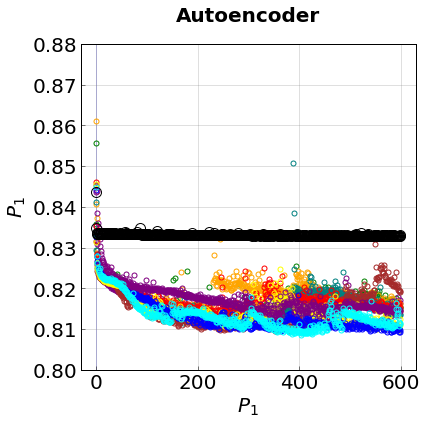

In [106]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'red', 'brown', 'yellow', 'blue', 'purple', 'cyan']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

for i in range(len(OP_set)):
    plt.plot(range(len(error_set[i])), error_set[i], marker='o', linewidth=0.0, markersize=5, color = colors[i], alpha=1.0, markerfacecolor='None')
    
plt.plot(range(len(error_linear)), error_linear, marker='o', linewidth=0.0, markersize=10, color = 'black', alpha=2.0, markerfacecolor='None') 

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
plt.ylim(0.8,0.88)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


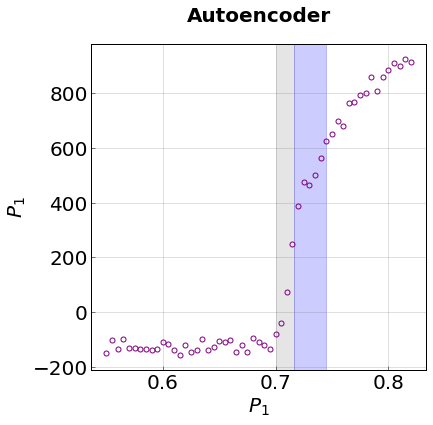

In [113]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'red', 'brown', 'yellow', 'blue', 'magenta', 'cyan']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

#for i in range(len(OP_set)):
    #plt.plot(etas, array(OP_set[i]), marker='o', linewidth=0.0, markersize=5, color = colors[i], alpha=1.0, markerfacecolor='None')
    
#plt.plot(etas, OP_linear, marker='o', linewidth=0.0, markersize=10, color = 'black', alpha=2.0, markerfacecolor='None') 
index = 1
plt.plot(etas, array(OP_set[index]), marker='o', linewidth=0.0, markersize=5, color = colors[index], alpha=1.0, markerfacecolor='None')

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

# Local structure analysis

In [88]:
from copy import deepcopy
from numpy import concatenate, log, power, rint, sqrt, sum, unique, repeat, arccos, dot, transpose, append, cos, sin, hstack, maximum, minimum, pi, array, mean
from numpy.linalg import norm
from numpy.random import shuffle, choice
from sklearn import preprocessing
import warnings

#this generates NN features for the PCA analysis (or some other machine learning method as well)
def FrameToFeaturesPosition(frame, N_nn, nn_inc, N_batch, batches_per_frame):
    #extract some relevant frames level details
    coords = deepcopy(frame['coords'])
    D = float(frame['D'])
    N = float(len(coords))
    V = power(frame['L'], D)
    normalizing_distance = power(V/N, 1.0/D)
    
    #loop over the batches
    aggregated_frame_features = []
    for i in range(batches_per_frame):
        coords_batch = coords[choice(int(N), N_batch, replace=False)]

        #loop over the particles
        frame_features = []
        for particle in coords_batch:
            #nearest neighbor coordinate wrapping
            Rpj_v = particle - coords
            Rpj_v = Rpj_v - rint(Rpj_v/frame['L'])*frame['L']
            Rpj = (sqrt(sum(power(Rpj_v, 2.0), axis=1)))     #tagged particles NN

            #sorting by the distance to enable the discovery of positional order
            sorter = Rpj.argsort()
            Rpj_v = Rpj_v[sorter[::1]][1:N_nn+1]
            Rpj = Rpj[sorter[::1]][1:N_nn+1]
            
            #calculate sorted distances between the NNs after moving reference frame to tagged particle
            features = deepcopy(Rpj)
            for i in range(len(Rpj_v)-1):
                nn_Rij_v = Rpj_v[i] - Rpj_v[i+1:]
                nn_Rij_v = nn_Rij_v - rint(nn_Rij_v/frame['L'])*frame['L']
                nn_Rij = (sqrt(sum(power(nn_Rij_v, 2.0), axis=1)))
                features = concatenate((features, nn_Rij), axis=0)
 
            #create features that correspond to probe particles and their nearest neighbors
            frame_features.append(features/normalizing_distance)

        #sort by the first nearest neighbor to again provide some positional basis on which to learn correlations
        #frame_features = array(frame_features)
        #sorter = frame_features[:,5].argsort()
        #frame_features = frame_features[sorter]
        
        #TEST
        #sorter = mean(frame_features, axis=1).argsort()
        #frame_features = frame_features[sorter]
        
        shuffle(frame_features)
        #TEST
        
        aggregated_frame_features.append(array(frame_features).flatten())

    return array(aggregated_frame_features)

#this converts an entire trajectory into features
def TrajectoryToFeaturesPosition(frames, N_nn, nn_inc, N_batch, batches_per_frame):
    #print filename
    features = []
    for frame in frames: 
        aggregated_frame_features = FrameToFeaturesPosition(frame, N_nn, nn_inc, N_batch, batches_per_frame)
        for frame_features in aggregated_frame_features:
            features.append(frame_features)
    return array(features)

In [492]:
filename = '../hoomd_disks/trajectories_4000p_longer/trajectory_0.7200.gsd'
#filename = '../hoomd_spheres/trajectories_4000p/quench_1/trajectories/trajectory_0.7000.gsd'

In [493]:
frames_r = ReadTraj(filename, traj_type='gsd', shuffle_data=False, randomize=True, remove_types=[])

In [494]:
frames = ReadTraj(filename, traj_type='gsd', shuffle_data=False, randomize=False, remove_types=[])

In [496]:
features_r = TrajectoryToFeaturesPosition(frames_r, N_nn=39, nn_inc=1, N_batch=1, batches_per_frame=40) #11

In [497]:
features = TrajectoryToFeaturesPosition(frames, N_nn=39, nn_inc=1, N_batch=1, batches_per_frame=40) #11

In [498]:
incpca_ig = IncrementalPCA(n_components=None, whiten=True)

In [499]:
incpca_ig.fit(features_r)

IncrementalPCA(batch_size=None, copy=True, n_components=None, whiten=True)

In [500]:
features_corrected = incpca_ig.transform(features)

In [501]:
dim = len(features_corrected[0])
print dim

780


In [502]:
from analysis_tools.autoencoder import AutoEncoder

In [503]:
model = AutoEncoder(dim=dim, encode_dim=1, 
                    initial_growth=0.25, shrink=0.65,
                    activation='elu')#, kernel_initializer='lecun_normal')

KeyboardInterrupt: 

In [504]:
model = AutoEncoder(dim=dim, encode_dim=1, 
                    initial_growth=0.25, shrink=0.25,
                    activation='elu')#, kernel_initializer='lecun_normal')

In [505]:
model.Compile(optimizer='adamax', loss='mean_squared_error')

In [506]:
print model.layer_dims

[975, 243, 60, 15, 3, 1, 3, 15, 60, 243, 975, 780]


In [507]:
features_corrected_train, features_corrected_test = train_test_split(features_corrected, test_size=0.25, random_state=42)

In [522]:
history_raw = model.Fit(features_corrected_train, features_corrected_test,
                epochs=1000, batch_size=500, shuffle=True)

Train on 30000 samples, validate on 10000 samples
Epoch 1/1000
30000/30000 [==============================] - 8s - loss: 1.0306 - val_loss: 1.0318
Epoch 2/1000
30000/30000 [==============================] - 8s - loss: 1.0302 - val_loss: 1.0313
Epoch 3/1000
30000/30000 [==============================] - 8s - loss: 1.0301 - val_loss: 1.0312
Epoch 4/1000
30000/30000 [==============================] - 8s - loss: 1.0297 - val_loss: 1.0311
Epoch 5/1000
30000/30000 [==============================] - 8s - loss: 1.0297 - val_loss: 1.0310
Epoch 6/1000
30000/30000 [==============================] - 8s - loss: 1.0294 - val_loss: 1.0307
Epoch 7/1000
30000/30000 [==============================] - 8s - loss: 1.0294 - val_loss: 1.0304
Epoch 8/1000
30000/30000 [==============================] - 8s - loss: 1.0295 - val_loss: 1.0309
Epoch 9/1000
30000/30000 [==============================] - 8s - loss: 1.0291 - val_loss: 1.0306
Epoch 10/1000
30000/30000 [==============================] - 8s - loss: 1.028

KeyboardInterrupt: 

In [523]:
pcs = model.Encode(features_corrected)

In [61]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#highlight the transition region if found
#plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
#plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

plt.plot(pcs[:,0], pcs[:,1], marker='o', linewidth=0.0, markersize=10, color = 'orange', alpha=0.1, markerfacecolor='None') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

In [524]:
from numpy import zeros

In [525]:
def CreateDistanceMatrix(features):
    num_features = len(features)
    N_try = 0
    num_features_try = N_try*(N_try-1)/2
    while num_features_try < num_features:
        N_try += 1
        num_features_try = N_try*(N_try-1)/2
    
    if num_features_try != num_features:
        return 'Bad data'
    
    #build the euclidean distance matrix
    N = N_try
    EDM = zeros((N,N))
    feature_index = 0
    for i in range(0, N):
        for j in range(i+1, N):
            EDM[i][j] = features[feature_index]
            EDM[j][i] = features[feature_index]
            feature_index += 1
    
    return EDM

In [526]:
from sklearn.manifold import MDS

In [527]:
mds_model = MDS(dissimilarity='precomputed')

In [54]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#plt.plot(ED_reconstructed[:,0], ED_reconstructed[:,1], marker='o', linewidth=0.0, markersize=20, color = 'blue', alpha=1.0, markerfacecolor='blue') 
plt.hist(pcs[:,0], bins=500, color = 'blue')

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

NameError: name 'pcs' is not defined

In [534]:
features_reconstructed = model.Decode(array([[0.2]]))[0]
features_reconstructed = incpca_ig.inverse_transform(features_reconstructed)
EDM = CreateDistanceMatrix(features_reconstructed)
ED_reconstructed = mds_model.fit_transform(EDM)

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


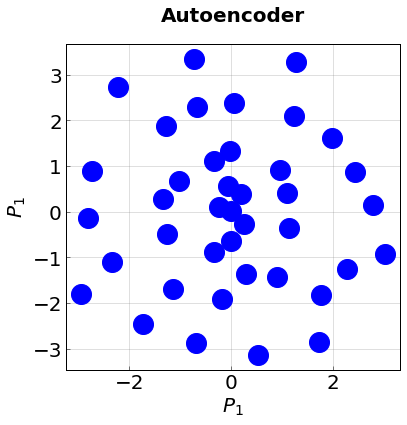

In [535]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(ED_reconstructed[:,0], ED_reconstructed[:,1], marker='o', linewidth=0.0, markersize=20, color = 'blue', alpha=1.0, markerfacecolor='blue') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


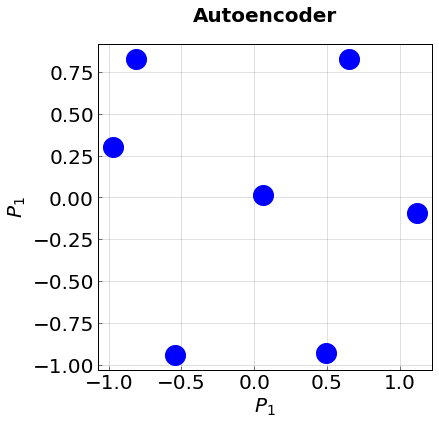

In [488]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(ED_reconstructed[:,0], ED_reconstructed[:,1], marker='o', linewidth=0.0, markersize=20, color = 'blue', alpha=1.0, markerfacecolor='blue') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


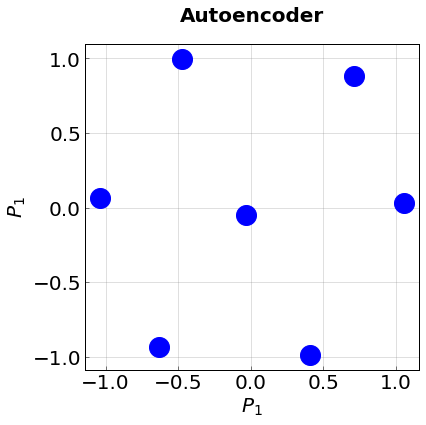

In [484]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(ED_reconstructed[:,0], ED_reconstructed[:,1], marker='o', linewidth=0.0, markersize=20, color = 'blue', alpha=1.0, markerfacecolor='blue') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

### Build a radial basis function network

In [131]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

In [140]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import Constant
import numpy as np

In [496]:
class RadiallyPositionedBasis(Layer):
    
    def __init__(self, output_dim, rcs, init_sigma=0.1, **kwargs):
        #self consistency check to ensure that the number of rcs equals 
        #the expected number of output dimensions
        self.rcs_dim = len(rcs)
        assert output_dim == self.rcs_dim
        
        self.output_dim = output_dim
        self.rcs = K.variable(value=rcs)
        self.init_sigma = init_sigma
        super(RadiallyPositionedBasis, self).__init__(**kwargs)

    def build(self, input_shape):
        #check that we are only using only scalar quantities 
        assert input_shape[1] == 1
        
        #create the optimizable standard deviations for the gaussian basis functions
        self.sigmas = self.add_weight(name='sigmas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(value=self.init_sigma),
                                     trainable=True)
        super(RadiallyPositionedBasis, self).build(input_shape)  

    def call(self, x):
        X = K.repeat_elements(x, self.rcs_dim, axis=1)
        return K.exp(-(self.rcs-X)**2.0)/self.sigmas

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RadiallyPositionedBasis, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [572]:
from keras.layers import Input, Dense
from keras.models import Model

In [607]:
rcs = arange(0.0, 5.0001, 1.0)
print rcs

r = Input(shape=(1,))
signal = RadiallyPositionedBasis(len(rcs), rcs, init_sigma=0.01)(r)
signal = Dense(len(rcs), activation='elu')(signal)
Fr = Dense(1, activation='linear')(signal)

# this model maps an input to its reconstruction
model = Model(r, Fr)

[ 0.  1.  2.  3.  4.  5.]


In [608]:
from numpy import cos, transpose

In [609]:
r_train = transpose([arange(0.0,5.0,0.0001)])
Fr_train = cos(r_train)

In [610]:
model.compile(optimizer='adamax', loss='mean_squared_error')

In [611]:
model.fit(r_train, Fr_train,
                epochs=50,
                batch_size=20,
                shuffle=True)

Epoch 1/50
50000/50000 [==============================] - 0s - loss: 6.5522     
Epoch 2/50
50000/50000 [==============================] - 0s - loss: 0.1371     
Epoch 3/50
50000/50000 [==============================] - 0s - loss: 0.0227     
Epoch 4/50
50000/50000 [==============================] - 0s - loss: 0.0027     
Epoch 5/50
50000/50000 [==============================] - 0s - loss: 8.8110e-04     
Epoch 6/50
50000/50000 [==============================] - 0s - loss: 3.0172e-04     
Epoch 7/50
50000/50000 [==============================] - 0s - loss: 1.5949e-04     
Epoch 8/50
50000/50000 [==============================] - 0s - loss: 9.3706e-05     
Epoch 9/50
50000/50000 [==============================] - 0s - loss: 6.1320e-05     
Epoch 10/50
50000/50000 [==============================] - 0s - loss: 5.2069e-05     
Epoch 11/50
50000/50000 [==============================] - 0s - loss: 4.3518e-05     
Epoch 12/50
50000/50000 [==============================] - 0s - loss: 3.7967e-0

In [606]:
model.fit(r_train, Fr_train,
                epochs=50,
                batch_size=20,
                shuffle=True)

Epoch 1/50
50000/50000 [==============================] - 0s - loss: 66.8001     
Epoch 2/50
50000/50000 [==============================] - 0s - loss: 2.3889     
Epoch 3/50
50000/50000 [==============================] - 0s - loss: 0.0704     - ETA: 0s - los
Epoch 4/50
50000/50000 [==============================] - 0s - loss: 1.2115e-04     
Epoch 5/50
50000/50000 [==============================] - 0s - loss: 1.1211e-04     
Epoch 6/50
50000/50000 [==============================] - 0s - loss: 9.3888e-05     
Epoch 7/50
50000/50000 [==============================] - 0s - loss: 7.1616e-05     
Epoch 8/50
50000/50000 [==============================] - 0s - loss: 5.7545e-05     
Epoch 9/50
50000/50000 [==============================] - 0s - loss: 4.7433e-05     
Epoch 10/50
50000/50000 [==============================] - 0s - loss: 4.0514e-05     
Epoch 11/50
50000/50000 [==============================] - 0s - loss: 3.6632e-05     
Epoch 12/50
50000/50000 [==============================] - 

In [612]:
Fr_predict = model.predict(r_train)

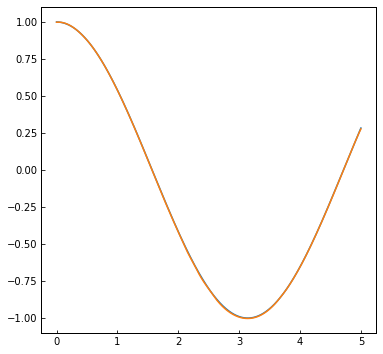

In [613]:
plt.plot(r_train, Fr_train)
plt.plot(r_train, Fr_predict)

In [620]:
from numpy.linalg import eigvalsh, eig

In [624]:
W = [[1,2,3],
     [2,1,4],
     [3,4,1]]
eig(W)

(array([ 7.07467358, -0.88679099, -3.1878826 ]),
 array([[ 0.50578521,  0.82403773, -0.25523155],
        [ 0.58437383, -0.54492509, -0.60130182],
        [ 0.63457746, -0.15497893,  0.75716113]]))

In [626]:
W = [[1,4,3],
     [4,1,2],
     [3,2,1]]
eig(W)

(array([ 7.07467358, -3.1878826 , -0.88679099]),
 array([[ 0.63457746,  0.75716113, -0.15497893],
        [ 0.58437383, -0.60130182, -0.54492509],
        [ 0.50578521, -0.25523155,  0.82403773]]))

In [622]:
W = [[1,2,4],
     [2,1,3],
     [4,3,1]]
eig(W)

(array([ 7.07467358, -3.1878826 , -0.88679099]),
 array([[-0.58437383, -0.60130182,  0.54492509],
        [-0.50578521, -0.25523155, -0.82403773],
        [-0.63457746,  0.75716113,  0.15497893]]))

In [625]:
W = [[1,2,3],
     [2,1,4],
     [3,4,1]]
eig(W)

(array([ 7.07467358, -0.88679099, -3.1878826 ]),
 array([[ 0.50578521,  0.82403773, -0.25523155],
        [ 0.58437383, -0.54492509, -0.60130182],
        [ 0.63457746, -0.15497893,  0.75716113]]))

In [ ]:
50*50

In [201]:
from keras.layers import Input, Dense, concatenate, Lambda
from keras.models import Model

#this is essentially a wrapper for keras that automates the building of an autencoder
#based on the initial dimensionality, target dimensionality, and how fast the layer 
#dimensions should shrink. this also includes an initial pre-expansion as is generally
#a good idea for autoencoders
class AutoEncoder:
    
    #determine the dimensions of the autoencoder (i.e., how big each layer is)
    def __init__(self, dim, encode_dim, num_clones,
                 initial_growth=0.10, shrink=0.75,
                 **kwargs):
        
        self.layer_dims = []
        self.encoded_layer = 0
        encode_data = Input(shape=(dim,)) 
        decode_data = Input(shape=(encode_dim,))
        
        
        ################################################
        ###build the encoder and decoder architecture###
        ################################################

        #initial expansion layer
        start_dim = int(dim*(1.0 + initial_growth))
        encoded = Dense(start_dim, **kwargs)(encode_data)
        self.layer_dims.append(start_dim)
        self.encoded_layer += 1

        #compression layers
        current_dim = int(start_dim*shrink)
        while current_dim > encode_dim:
            encoded = Dense(current_dim, **kwargs)(encoded)
            self.layer_dims.append(current_dim)
            self.encoded_layer += 1
            current_dim = int(current_dim*shrink)
        
        #final encoding layer
        #encoded = Dense(encode_dim, **kwargs)(encoded)
        encoded = Dense(encode_dim, activation='linear')(encoded) 
        self.layer_dims.append(encode_dim)
        self.encoded_layer += 1
        
        #first expansion layer
        reversed_dims = self.layer_dims[::-1][1:]
        decoded = Dense(reversed_dims[0], **kwargs)(decode_data)
        self.layer_dims.append(reversed_dims[0])
        self.encoded_layer += 1
        
        #remaining expansion layers
        for current_dim in reversed_dims[1:]:
            decoded = Dense(current_dim, **kwargs)(decoded)
            self.layer_dims.append(current_dim)
            
        #final linear layer
        decoded = Dense(dim, activation='linear')(decoded)
        self.layer_dims.append(dim)
        
        #create encoder and decoder models
        self.encoder = Model(encode_data, encoded)
        self.decoder = Model(decode_data, decoded)
        
        #create the joint model
        _encoded_ = self.encoder(encode_data)
        _decoded_ = self.decoder(_encoded_)
        self.autoencoder = Model(encode_data, _decoded_)
        
        
        #########################################
        ###build the coupled autoencoder model###
        #########################################
        
        #read in joint data and split into the columns
        joint_input = Input(shape=(dim*num_clones,))
        split_input = []
        for i in range(num_clones):
            split_input.append( Lambda(lambda x : x[:,i*dim:(i+1)*dim], output_shape=(dim,))(joint_input) )
            
        #spit out the results and concatenate
        split_output = [self.autoencoder(input) for input in split_input]
        if num_clones == 1:
            joint_output = split_output[0]
        else:
            joint_output = concatenate(split_output, axis=-1)
        
        #final model
        self.autoencoder = Model(joint_input, joint_output)

        ####create the joint model
        ####_encoded_ = self.encoder(encode_data)
        ####_decoded_ = self.decoder(_encoded_)
        ####self.autoencoder = Model(encode_data, _decoded_)
        
        return None
    
    def Compile(self, **kwargs):
        return self.autoencoder.compile(**kwargs)
    
    def Fit(self, features_train, features_test, **kwargs):
        if 'validation_data' in kwargs:
            return self.autoencoder.fit(features_train, 
                                        features_train, 
                                        **kwargs)
        else:
            return self.autoencoder.fit(features_train, 
                                        features_train,  
                                        validation_data=(features_test, features_test), 
                                        **kwargs)
        
    def Encode(self, features, **kwargs):
        return self.encoder.predict(features, **kwargs)
    
    def Decode(self, features, **kwargs):
        return self.decoder.predict(features, **kwargs)
    
    def Summary(self, **kwargs):
        return self.autoencoder.summary(**kwargs)

In [187]:
for input in [1,2,3]:
    print input

1
2
3
